[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/tp/01_aprendizaje_supervisado/tp01-enunciado.ipynb)

# Trabajo Práctico -  Aprendizaje supervisado
### Clasificación de expresiones genómicas

<span style="color: red;">**Fecha de entrega: 01 de Mayo del 2024 - hasta las 23:55hs.**

<span style="color: red;">**Fecha de entrega intermedia: 25 de Abril del 2024 - hasta las 23:55hs.**
</span>

## Introducción

En el mundo actual, distintas disciplinas científicas empiezan, cada vez más, a interactuar con el fin de potenciar sus descubrimientos. En este caso dos grupos de investigación de [CONICET](https://www.conicet.gov.ar/) se embarcan en la combinación entre biología y informática para abordar la detección temprana y el pronóstico preciso de enfermedades como el cáncer. Este proyecto combina las tecnologías de secuenciación de nueva generación ([_NGS_](https://es.wikipedia.org/wiki/Secuenciaci%C3%B3n_paralela_masiva), por sus siglas en inglés) con la potencia de la inteligencia artificial. El enfoque se centra en un dataset único que abarca mediciones de [_ARN_](https://es.wikipedia.org/wiki/ARN_mensajero) de 200 [_genes_](https://es.wikipedia.org/wiki/Gen), recopiladas de pacientes con lesiones [_pre-tumorales_](https://en.wikipedia.org/wiki/Hyperplasia). Este conjunto de datos se convierte en una valiosa fuente de información para entender cómo las células en estado de hiperplasia pueden evolucionar hacia [_tumores malignos_](https://en.wikipedia.org/wiki/Neoplasm), una transformación que ha desconcertado a la ciencia durante décadas.

La hiperplasia, es un fenómeno en el que las células experimentan un crecimiento anormal y descontrolado, es un punto de partida crucial en nuestro análisis. ¿Cómo y por qué algunas células que experimentan hiperplasia se convierten en células cancerosas, mientras que otras no? Esta pregunta es el corazón de nuestra investigación. Para responderla se realizo un estudio donde se obtuvieron muestras de distintos tipos de hiperplasias de pacientes con antecedentes familiares y lesiones pre tumorales. Este grupo de pacientes, o cohorte, fue monitoreado periodicamente durante los siguientes 5 años buscando indicios de neoplasias o nuevas hiperplasias más agresivas. Con las muestras obtenidas en este estudio se realizo un [_biobanco_](https://en.wikipedia.org/wiki/Biobank) con las mediciones que habitualmente se hacen en la construccion de este tipo de [_plataformas_](https://xena.ucsc.edu/). Cada muestra fue etiquetada como **_buen pronostico_**, si no hubo indicios de nuevas hiperplasias o similares; contrariamente se etiquetaron como de **_mal pronostico_** si hubo una recaida.

Este trabajo se concentra en un panel de genes, especificamente en la expresion de 200 genes que se creen tienen un papel crucial en la transformacion tumoral y su etiqueta correspondiente.

En concreto:

Tendrán un archivo `.csv` en donde se almacenan:
  - una matriz de datos `X` de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$.
  - una columna llamada `target` que representa un vector de $500$ posiciones con dos posibles valores: `True` (ó 1, es decir, tiene buen pronostico) y `False` (ó 0, tiene mal pronostico).

Los datos están en esta [carpeta](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

Por otra parte, tendrán disponibles un conjunto de instancias sin etiquetas, que utilizaremos para comprobar la calidad de sus resultados (ver Ejercicio 5). 

**Recomendamos fuertemente leer primero todo el enunciado del trabajo antes de empezar a trabajar sobre el problema propuesto.**

---

### Sobre el informe

Para este trabajo deberán entregar, además del código de las pruebas y experimentos que realicen, un informe en el que deberan seleccionar, para cada apartado, sus resultados acompañado de un texto que explique, reflexione, justifique y conluya dicho contenido. 

Cada ejercicio indica el largo máximo del texto que se puede incluir. Los gráficos no están contados en dicho espacio. 
Cada gráfico incluido debe contar con:
  
  - nombres de los ejes,
  - título,
  - leyenda autocontenida,
  - debe ser referenciado desde el texto, ya que su inclusión se da porque aporta a la discusión del trabajo.

---

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import BaseCrossValidator
from sklearn.model_selection import RandomizedSearchCV

from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 

from abc import ABC, abstractmethod
from typing import Tuple, Callable
from typing_extensions import Self

## Ejercicio 1 

### Separación de datos (máximo 2 carillas del informe)

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. 

Evaluar y justificar cómo separarán sus datos para desarrollo y para evaluación. 

**Importante**: en este punto no está permitido dividir la base de datos utilizando la función `train_test_split` de sklearn. Deben decidir e implementar la separación.

In [14]:

def train_test_split(
    X: np.ndarray, 
    y: np.ndarray, 
    train_size: float = 0.9, 
    seed: int = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    params
    ------
        y : np.ndarray 0-1 target labels corresponding to X
    """
    generator = np.random.default_rng(seed)
    
    pMask = y == 1
    pInstances = X[pMask]
    nInstances = X[~pMask]

    generator.shuffle(pInstances)
    generator.shuffle(nInstances)

    X_pTrain, X_pTest = np.split(pInstances, [int(len(pInstances)*train_size)])
    X_nTrain, X_nTest = np.split(nInstances, [int(len(nInstances)*train_size)])

    X_train = np.concatenate((X_pTrain, X_nTrain))
    y_train = np.array([1] * len(X_pTrain) + [0] * len(X_nTrain))
    trainShuffle = generator.permutation(len(y_train))

    X_test = np.concatenate((X_pTest, X_nTest))
    y_test = np.array([1] * len(X_pTest) + [0] * len(X_nTest))
    testShuffle = generator.permutation(len(y_test))

    return X_train[trainShuffle], X_test[testShuffle], y_train[trainShuffle], y_test[testShuffle]

gene_dataset = pd.read_csv("../catedra/datos/data.csv", delimiter=',', encoding="utf-8")
X = gene_dataset.drop("target", axis=1).to_numpy()
y = gene_dataset.target.to_numpy()

# we set a seed value to guarantee dev. re-runs do not change the data split (also, to allow reproduction)
seed = 0x2031
X_train, X_test, y_train, y_test = train_test_split(X, y, seed=seed)


## Ejercicio 2


### Construcción de modelos (máximo 2 carillas del informe)

Para este punto, la tarea consiste en construir y evaluar modelos de tipo **árbol de decisión**. Además, obtener una **estimación realista de la performance** de los mismos.

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default.

1. Estimar la performance del modelo utilizando _K-fold cross validation_ con `K=5`, con las métricas _Accuracy_, _Area Under the Precision-Recall Curve (AUPRC)_., _Area Under the Receiver Operating Characteristic Curve (AUCROC)_. 

   En esta oportunidad se va a pedir además de calcular las métricas para cada fold por separado y su promedio, que hagan el cálculo del score global (como vimos en clase), sólo para los folds de validación.
   
   Reportar el resultado en una tabla similar a:

      <table>
      <thead>
      <tr>
      <th align="center">Permutación</th>
      <th>Accuracy (training)</th>
      <th>Accuracy (validación)</th>
      <th>AUPRC (training)</th>
      <th>AUPRC (validación)</th>
      <th>AUC ROC (training)</th>
      <th>AUC ROC (validación)</th>
      </tr>
      </thead>
      <tbody>
      <tr>
      <td align="center">1</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">2</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">3</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">4</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">5</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <tr>
      <td align="center">Promedios</td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      </tr>
      <td align="center">Global</td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      <td>(NO) </td>
      <td></td>
      </tr>
      </tbody>
      </table>    
  
   **Importante**: de acá en más sólamente utilizaremos el score promedio cuando hagamos _K-fold cross-validation_.
 
1. Explorar las siguientes combinaciones de parámetros para  árboles de decisión (siguiendo con $k-fold$ con $k=5$) utilizando [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) de _scikit learn_. No está permitido utilizar `GridSearchCV` en este ejercicio.

   <table>
   <thead>
   <tr>
   <th align="center">Altura máxima</th>
   <th align="center">Criterio de corte</th>
   <th>Accuracy (training)</th>
   <th>Accuracy (validación)</th>
   </tr>
   </thead>
   <tbody><tr>
   <td align="center">3</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Gini</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">3</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">5</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   <tr>
   <td align="center">Infinito</td>
   <td align="center">Entropía</td>
   <td></td>
   <td></td>
   </tr>
   </tbody></table>


1. ¿Qué conclusiones se pueden sacar de estas tablas?  

In [15]:
class EstimatorWrapper(ABC):
    estimator: BaseEstimator
    
    @abstractmethod
    def __init__(self):
        pass

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.estimator.fit(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.estimator.predict(X)

    @abstractmethod
    def decision(self, X: np.ndarray) -> np.ndarray:
        """
        wrapper for predict_proba or decision_function
        """
        pass

    def clone(self) -> Self:
        return type(self)(**self.estimator.get_params())


class DecisionTreeWrapper(EstimatorWrapper):
    estimator: DecisionTreeClassifier

    def __init__(self, **kwargs):
        self.estimator = DecisionTreeClassifier(**kwargs)

    def decision(self, X: np.ndarray) -> np.ndarray:
        return self.estimator.predict_proba(X)[:, 1]


class SVCWrapper(EstimatorWrapper):
    estimator: SVC

    def __init__(self, **kwargs):
        self.estimator = SVC(**kwargs)

    def decision(self, X: np.ndarray) -> np.ndarray:
        return self.estimator.decision_function(X)


In [16]:
def cross_validate(
    estimator: EstimatorWrapper,
    X: np.ndarray, 
    y: np.ndarray, 
    metric: Callable[[np.ndarray, np.ndarray], float],
    use_decision: bool,
    cv: BaseCrossValidator,
) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Params
    ------
    use_decision : bool
        should metric be called with estimator's .predict or .decision output
    
    Returns
    -------
    results : pd.DataFrame
        pandas DataFrame with columns:
            mean_val : float
                the mean value of split_val

            mean_train : float
                the mean value of split_train

            tot_val : float
                the evaluation of the metric on y and y_pred
    
            split_val_[0:k) : float
                each cross-validation model's evaluated metric on its validation set
    
            split_train_[0:k): float
                each cross-validation model's evaluated metric on its train set

    y_pred : np.ndarray
        the whole prediction / decision results on validation. ie. each 
        instance's prediction / decision value from the cross-validation model 
        that evaluated it on validation.
    """
    y_pred = np.zeros(y.shape, dtype=float)
    k = cv.get_n_splits()
    split_metrics_train = np.zeros(k)
    split_metrics_val = np.zeros(k)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[test_idx], y[test_idx]
        model = estimator.clone()
        model.fit(X_train, y_train)
        if use_decision:
            pred_train = model.decision(X_train)
            pred_val = model.decision(X_val)
        else:
            pred_train = model.predict(X_train)
            pred_val = model.predict(X_val)
        split_metrics_train[idx] = metric(y_train, pred_train)
        split_metrics_val[idx] = metric(y_val, pred_val)
        y_pred[test_idx] = pred_val

    data = np.hstack((np.array([
        split_metrics_val.mean(),
        split_metrics_train.mean(),
        metric(y, y_pred)
    ]), split_metrics_val, split_metrics_train)).reshape((1, 3+2*k))
    result = pd.DataFrame(
        data,
        index=[metric.__name__],
        columns=["mean_val", "mean_train", "tot_val"] + \
            [f"split_val_{i}" for i in range(k)] + \
            [f"split_train_{i}" for i in range(k)]
    )

    return result, y_pred


In [17]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return accuracy_score(y_true, y_pred)


def auprc(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)


def aucroc(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    fpr, recall, _ = roc_curve(y_true, y_prob)
    return auc(fpr, recall)


In [18]:
# ej. 2.1
simple_model = DecisionTreeWrapper(max_depth=3, random_state=seed)

auprc


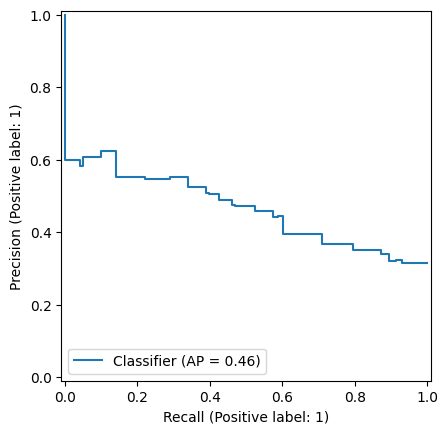

aucroc


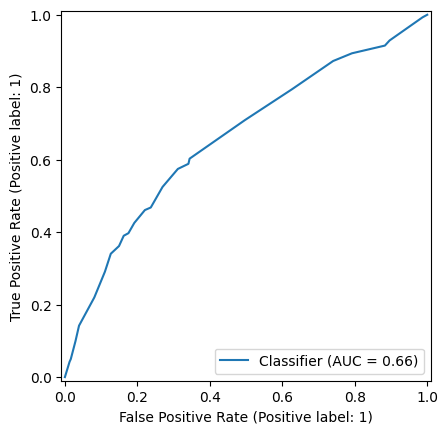

,mean_val,mean_train,tot_val,split_val_0,split_val_1,split_val_2,split_val_3,split_val_4,split_train_0,split_train_1,split_train_2,split_train_3,split_train_4
accuracy,0.690512,0.820720,0.690423,0.733333,0.655556,0.633333,0.700000,0.730337,0.832869,0.818942,0.824513,0.818942,0.808333
auprc,0.486581,0.767063,0.480965,0.501879,0.354457,0.560316,0.457227,0.559025,0.767635,0.761756,0.768877,0.755060,0.781986
aucroc,0.641391,0.819662,0.658964,0.627016,0.634217,0.669931,0.622103,0.653689,0.786909,0.810256,0.846014,0.788968,0.866164


In [19]:
# ej. 2.2
k = 5
mxp = [
    (accuracy, None, False), 
    (auprc, PrecisionRecallDisplay, True), 
    (aucroc, RocCurveDisplay, True)
]
res = []
for metric, plotter, use_decision in mxp:
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    data, y_prob = cross_validate(simple_model, X_train, y_train, metric, use_decision, cv)
    res.append(data)
    if plotter:
        print(metric.__name__)
        plotter.from_predictions(y_train, y_prob)
        plt.show()
df = pd.concat(res)
df

In [20]:
# ej. 2.3
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
grid = {
    "random_state": [seed],
    "max_depth": [3, 5, None],
    "criterion": ["gini", "entropy"],
}
keys = grid.keys()
res = []
for hs in ParameterGrid(grid):
    model = DecisionTreeWrapper(**hs)
    data, _ = cross_validate(model, X_train, y_train, accuracy, False, cv)
    res.append([hs[x] for x in keys]+[data.mean_train.accuracy, data.mean_val.accuracy])
df = pd.DataFrame(
    res,
    columns=list(keys)+["accuracy_train", "accuracy_val"]
)
df

,random_state,max_depth,criterion,accuracy_train,accuracy_val
0,8241,3.0,gini,0.820720,0.690512
1,8241,5.0,gini,0.912567,0.712684
2,8241,NaN,gini,1.000000,0.663720
3,8241,3.0,entropy,0.788983,0.681498
4,8241,5.0,entropy,0.893655,0.650312
5,8241,NaN,entropy,1.000000,0.645918


## Ejercicio 3

### Comparación de algoritmos 


Se pide explorar distintas combinaciones de algoritmos de aprendizaje con diferentes configuraciones con el objetivo de encontrar el mejor modelo de cada familia de buscar la performance óptima. Para este ejercicio realizar una experimentación utilizando [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Como métrica de performance usar AUCROC resultante de 5-fold cross-validation. 

Algoritmos a probar: 
  - Árboles de decisión
  - KNN (k-vecinos más cercanos)
  - SVM (Support vector machine)
  - LDA (Linear discriminant analysis)
  - Naïve Bayes
  
_Hiperparámetros_: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras. 

Documentación extra sobre [`Tuning hyper-parameters`](https://scikit-learn.org/stable/modules/grid_search.html), leer hasta 3.2.2.

Para este ejercicio se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

Para cada método pueden incluir hasta media carilla de texto y los gráficos que considere relevantes.

In [21]:
class logUnifD:
    distr: stats.loguniform

    def __init__(self, *args, **kwds):
        self.distr = stats.loguniform(*args, **kwds)
    
    def rvs(self, *args, **kwds):
        samples = self.distr.rvs(*args,**kwds)
        discretized_samples = np.round(samples).astype(int)
        return discretized_samples


class pNpUniform:
    distr: stats.uniform

    def __init__(self ,*args, **kwds):
        self.distr = stats.uniform(*args,**kwds)
    
    def rvs(self, *args, **kwds):
        sample = self.distr.rvs(*args, **kwds)
        return sample, 1 - sample

class pNpNormal:
    distr: stats.norm

    def __init__(self ,*args, **kwds):
        self.distr = stats.norm(*args,**kwds)
    
    def rvs(self, *args, **kwds):
        sample = self.distr.rvs(*args, **kwds)
        if sample < 0:
            sample = 0
        if sample > 1:
            sample = 1
        return sample, 1 - sample


def rs_results(cv_results: dict, params: dict) -> pd.DataFrame:
    columns_to_keep = [f"param_{param}" for param in params.keys()] + ['mean_test_score','rank_test_score']
    return pd.DataFrame(cv_results).sort_values("rank_test_score")[columns_to_keep]

### Árboles de decisión
---

In [22]:
model = DecisionTreeClassifier(random_state=seed)
p = X_train.shape[1]
n_iter = X_train.shape[0]
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": stats.randint(3, np.floor(np.sqrt(n_iter))),
    "max_features": stats.randint(1, p),
    
}
n_iter = 100
classifier_Dtree = RandomizedSearchCV(estimator=model, 
                                    param_distributions=params, 
                                    n_iter=n_iter, 
                                    cv=cv, 
                                    scoring='roc_auc',
                                    random_state=seed)
classifier_Dtree.fit(X_train, y_train)
rs_results(classifier_Dtree.cv_results_, params)

,param_criterion,param_max_depth,param_max_features,mean_test_score,rank_test_score
46,entropy,3,135,0.684278,1
55,entropy,3,14,0.659835,2
27,log_loss,4,148,0.651703,3
85,log_loss,3,77,0.651348,4
60,entropy,9,91,0.646844,5
...,...,...,...,...,...
94,entropy,17,165,0.534934,96
65,log_loss,11,21,0.533663,97
17,gini,7,24,0.528307,98
12,log_loss,3,17,0.523766,99


### KNN
---

In [23]:
model = KNeighborsClassifier()
K = X_train.shape[0]
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
params = {
    'n_neighbors': logUnifD(10, K/2),
    'weights': ['uniform', 'distance'],
    #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': stats.randint(1, 4), # minkowski metric
}
n_iter = 100
classifier_KNN = RandomizedSearchCV(estimator=model, 
                                param_distributions=params,
                                cv=cv,
                                n_iter=n_iter,
                                scoring="roc_auc", 
                                random_state=seed)
classifier_KNN.fit(X_train,y_train)
rs_results(classifier_KNN.cv_results_, params)

,param_n_neighbors,param_weights,param_p,mean_test_score,rank_test_score
6,15,distance,1,0.839120,1
19,11,distance,1,0.838640,2
0,14,distance,1,0.837595,3
64,13,distance,1,0.836097,4
97,26,distance,1,0.828764,5
...,...,...,...,...,...
26,200,distance,3,0.747929,96
93,165,uniform,3,0.742176,97
80,171,uniform,3,0.741821,98
32,198,uniform,3,0.740723,99


### SVM
---

In [24]:
model = SVC(random_state=seed)
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
params = {
    'C': stats.uniform(1e-16, 1), 
    'gamma': ['scale', 'auto'],
    'kernel': ["rbf", "linear", "poly", "sigmoid"],
    'degree': stats.randint(2, 10)
}
n_iter = 100
classifier_SVM = RandomizedSearchCV(estimator=model, 
                                param_distributions=params,
                                cv=k,
                                n_iter=n_iter,
                                scoring="roc_auc", 
                                random_state=seed)
classifier_SVM.fit(X_train, y_train)
rs_results(classifier_SVM.cv_results_, params)

,param_C,param_gamma,param_kernel,param_degree,mean_test_score,rank_test_score
80,0.901067,scale,rbf,8,0.873475,1
60,0.875746,scale,rbf,3,0.872442,2
71,0.79047,scale,rbf,6,0.869464,3
37,0.772139,scale,rbf,7,0.869121,4
4,0.774049,scale,rbf,6,0.869121,4
...,...,...,...,...,...,...
40,0.842751,auto,sigmoid,7,0.625289,96
81,0.911703,auto,sigmoid,7,0.624806,97
44,0.932612,auto,sigmoid,2,0.615937,98
67,0.717453,scale,poly,8,0.611388,99


### LDA
---

In [25]:
model = LinearDiscriminantAnalysis()
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
params = {
    'solver': ["lsqr","eigen"], 
    #'priors': pNpUniform(0, 1),
    #'tol': stats.uniform(0, 1e-2),
    'shrinkage': stats.uniform(0,1),
    #'store_covariance': [True,False],
}
n_iter = 100
classifier_LDA = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                cv=cv,
                                n_iter=n_iter,
                                scoring="roc_auc",
                                random_state=seed)
classifier_LDA.fit(X_train, y_train)
rs_results(classifier_LDA.cv_results_, params)

,param_solver,param_shrinkage,mean_test_score,rank_test_score
68,lsqr,0.272309,0.864894,1
40,eigen,0.270007,0.864894,1
46,lsqr,0.266565,0.864894,3
56,lsqr,0.274341,0.864779,4
92,eigen,0.288274,0.864552,5
...,...,...,...,...
58,eigen,0.976675,0.777749,96
12,lsqr,0.981865,0.774629,97
55,eigen,0.00662,0.767595,98
54,eigen,0.005946,0.764031,99


### Naïve Bayes
---

In [26]:
model = GaussianNB()
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
nPrior = np.count_nonzero(y_train == 0) / np.size(y_train)
params = {
    # "priors": pNpUniform(0, 1), esto prob. es overfiteo. Deberiamos testear a lo sumo alrededor de las prob. estimadas del set
    "priors": pNpNormal(nPrior, 0.1), # Esto deberia de ser una normal centrada en el prior de la clase negativa con poquita deviacion estandard, pero podria estar mal hay que checkear
    "var_smoothing": stats.uniform(0, 1e-2)
}
n_iter = 100
classifier_NBayes = RandomizedSearchCV(estimator=model, 
                                    param_distributions=params, 
                                    n_iter=n_iter, 
                                    cv=cv, 
                                    scoring='roc_auc',
                                    random_state=seed)
classifier_NBayes.fit(X_train, y_train)
rs_results(classifier_NBayes.cv_results_, params)

,param_priors,param_var_smoothing,mean_test_score,rank_test_score
41,"(0.6316765947235525, 0.36832340527644747)",0.009751,0.840805,1
11,"(0.6116385394140161, 0.38836146058598386)",0.009733,0.840805,1
47,"(0.8179538336772022, 0.1820461663227978)",0.009801,0.840692,3
4,"(0.65760892214815, 0.34239107785184997)",0.009819,0.840692,3
26,"(0.5154352418282895, 0.4845647581717105)",0.009596,0.840692,5
...,...,...,...,...
6,"(0.5826247348274607, 0.4173752651725393)",0.000252,0.791158,96
29,"(0.6949662658483393, 0.3050337341516607)",0.000172,0.790466,97
52,"(0.661575943206341, 0.33842405679365894)",0.000156,0.790121,98
51,"(0.7626627905796638, 0.2373372094203362)",0.000132,0.789434,99


## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza.

<span style="color: red;">(no realizar hasta la clase _Sesgo y Varianza_)</span>

En este punto, se pide inspeccionar **tres** de sus mejores modelos encontrados hasta ahora de cada familia de modelos: la mejor configuración para el árbol de decisión, la mejor configuración para LDA y la mejor configuración para SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo (excepto para LDA), variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo **RandomForest** con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos.


**Atención**: Tener en cuenta que debemos seguir utilizando AUC ROC como métrica para estas curvas.

Para cada método pueden incluir hasta una carilla de texto y los gráficos que considere relevantes.


## Ejercicio 5: 
### Evaluación de performance

- La entrega del trabajo estará acompañada de una evaluación en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

- Su tarea será estimar la performance (AUCROC) que tendrá su mejor modelo en datos de evaluación (X_held_out). 

- Para ello, deberán predecir las **probabilidades** de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUCROC resultante y calcularemos el resultado real. Consideraremos que el **mejor modelo será el que se encuentre más cerca del valor real que calcularemos luego de la entrega**.

- Recomendamos no perder de vista esta evaluación/competencia durante el desarrollo del TP, sobretodo en el momento de separar los datos en los primeros puntos. 

- Para que podamos evaluar la performance, junto con la entrega del informe, deberán enviar un archivo con el numero de grupo con dos digitos en formato csv con la columna `output` y el valor obtenido con 4 decimales (se subirá un ejemplo cuando se publiquen los datos de la competencia) y un valor esperado de AUCROC: `GG_y_pred_held_out_AUCROC`. 

    - Ej.: el grupo tres cree que obtuvo un valor de 0.7321 de AUCROC deberá submitear un archivo llamado: `03_y_pred_held_out_7321.csv`.

- Los datos podrán encontrarlos en este [link](https://github.com/aprendizaje-automatico-dc-uba-ar/material/tree/main/tp/01_aprendizaje_supervisado/datos).

- Las decisiones de este punto pueden desarrollarse hasta en una carilla, aunque con media debería alcanzar.


### Model Performance
---

accuracy: 0.7254901960784313
auprc: 0.631046785197249


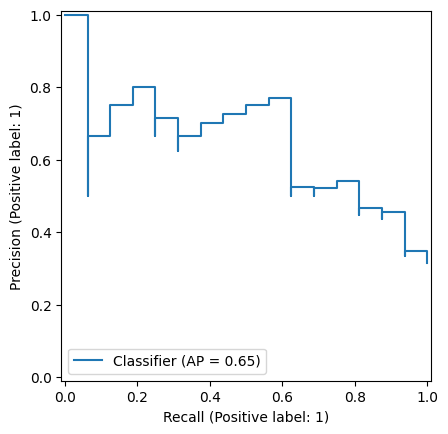

aucroc: 0.7928571428571428


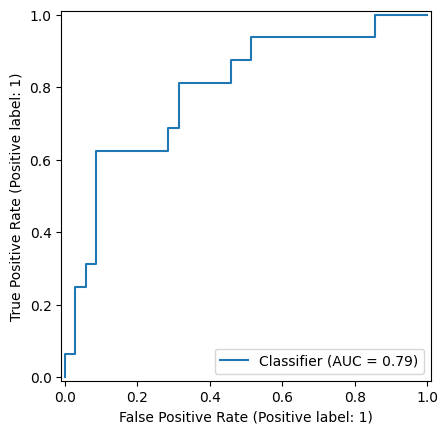

In [27]:
# TODO: Agregar modelo final
best_params = classifier_SVM.best_params_
model = SVC(probability=True, **best_params) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)
mxp = [
    (accuracy, None, None),
    (auprc, PrecisionRecallDisplay, True), 
    (aucroc, RocCurveDisplay, True)
]

for metric, plotter, use_decision in mxp:
    y_score = y_prob if use_decision else y_pred
    print(f"{metric.__name__}: {metric(y_test, y_score)}")
    if plotter:
        plotter.from_predictions(y_test, y_score)
        plt.show()

### Competencia
---

In [28]:
# Find both thresholds for proba: 
# if (proba(X_held_out_i) > pTHRESH) -> prediction is correct and positive
# if (proba(X_held_out_i) < nTHRESH) -> prediction is correct and negative

probas = [proba_p for (proba_n, proba_p) in model.predict_proba(X_test)]
correctProbas = [pred_i == test_i for (pred_i, test_i) in zip(y_pred, y_test)]
pTHRESHvals = [proba for (proba, pred, correct) in zip(probas, y_pred, correctProbas) if (correct and pred == 1)]
nTHRESHvals = [proba for (proba, pred, correct) in zip(probas, y_pred, correctProbas) if (correct and pred == 0)]

# print(f'pTHRESH_min: ({min(pTHRESHvals)})')
# print(f'pTHRESH_max: ({max(pTHRESHvals)})')
# print(f'nTHRESH_min: ({min(nTHRESHvals)})')
# print(f'nTHRESH_max: ({max(nTHRESHvals)})')

# We take the averages as thresholds
pTHRESH = sum(pTHRESHvals) / len(pTHRESHvals)
nTHRESH = sum(nTHRESHvals) / len(nTHRESHvals)

print(f'(pTHRESH, nTHRESH) = ({pTHRESH}, {nTHRESH})')

(pTHRESH, nTHRESH) = (0.8091536881435968, 0.1631520785687964)


Bueno esto creo que termino siendo medio bastante flasheada, si lo corren van a ver que da bastante alto el aucorc (0.84), asi que quizas habria que revisar esto

In [29]:
X_held_out = pd.read_csv("../catedra/datos/X_held_out.csv", delimiter=',', encoding="utf-8").to_numpy()

y_pred = model.predict(X_held_out)
y_probas = model.predict_proba(X_held_out)[:,1]
# print(y_probas)
# print(len(y_probas))

y_held_out = []
print(f'{pTHRESH}, {nTHRESH}')
for pred, proba in zip(y_pred, y_probas):
    # print(f'{pred}, {proba}')
    if (pred == 1 and proba >= pTHRESH) or (pred == 0 and proba <= nTHRESH):
        y_held_out.append(pred)
    else:
        y_held_out.append(abs(pred-1))

prediction = roc_auc_score(y_held_out, model.decision_function(X_held_out))
print(prediction)

formated_aucroc = f'{prediction:.4f}'.split('.')[1]
file_path = f'./out/TEST_08_y_pred_held_out_{formated_aucroc}.csv'
pd.DataFrame({'output': y_probas}).to_csv(file_path, index=False)

0.8091536881435968, 0.1631520785687964
0.876231884057971


## Ejercicio 6: 
### Conclusiones

Dar en a lo sumo 2 carillas una conclusión del trabajo realizado, incluyendo problemas encontrados y 
dimensiones no incluidas en el enunciado que hayan sido abordadas durante el desarrollo.

---
## Entregables
- Contarán con un esqueleto en formato Jupyter Notebook en donde podrán intercalar celdas para reportar y responder a los ítems de cada ejercicio. 
- Los entregrables serán
    - Un informe en formato .pdf (**digital**) que responda a los ítems de este enunciado respetando la cantidad de espacio máximo por cada ítem. Nombrarlo siguiendo el formato `GG_Nombre_de_grupo`
    - Adjuntar el notebook final en formatos .pdf e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (verificarlo haceindo: Kernel -> Restart and Run All). 
    - Las predicciones del *held out* del punto 5 en formato csv.
- Habŕa una entrega intermedia obligatoria que deberán hacer antes del 25 de abril de 2024 a las 23:55hs. Para esta entrega deberán enviar el código que resuelve los primeros 3 ejercicios. 
- La **fecha** y **hora límite** de entrega está determinada en el campus de la materia.
- El trabajo deberá elaborarse en grupos de hasta 4 personas (4 preferentemente).
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.


### Importante: sobre el uso de ChatGPT y grandes modelos de lenguaje

En este trabajo no estará explícitamente prohibido pero si fuertemente desaconsejado, consideramos a este trabajo práctico una importante herramienta de aprendizaje donde el uso de GPT puede ser perjudicial. En caso de usarlo se pide aclararlo en el informe y especificar cómo y en donde se utilizó. Así como expresar su opinión sobre la respuesta generada por el modelo pudiendo estar a favor o en contra de lo propuesto por este. Pueden adjuntar el link a la conversación con el modelo.

**Nota**: Agradecemos a [Martín García Sola](https://ar.linkedin.com/in/martin-e-garcia-sola) por la asistencia biológica en la confección de este Trabajo Práctico.